In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
import geopandas as gpd
from shapely.geometry import Point
from zipfile import ZipFile

In [3]:
# Notebook Styling 
# sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

In [185]:
class ComplaintHist:
    COMPLAINT_HIST_PATH = os.path.join('..', 'data_raw', 'complaint', 'NYPD_Complaint_Data_Historic.csv')
    
    def __init__(self, filepath=COMPLAINT_HIST_PATH):
        self.data = pd.read_csv(filepath)
        self.preprocess_data()
        
    def preprocess_data(self):
        self.data.drop(['X_COORD_CD', 'Y_COORD_CD', 'Lat_Lon'], axis=1, inplace=True)
        self.data['JURISDICTION_CODE'] = self.data['JURISDICTION_CODE'].fillna(-99).astype(int).astype(str)
        self.data['ADDR_PCT_CD'] = self.data['ADDR_PCT_CD'].fillna(-99).astype(int).astype(str)
        self.data['PD_CD'] = self.data['PD_CD'].fillna(-99).astype(int).astype(str)
        self.data.dropna(subset=['Latitude', 'Longitude'], how='all', axis=0, inplace=True)
        self.data.dropna(subset=['CMPLNT_FR_DT', 'CMPLNT_TO_DT'], how='all', axis=0, inplace=True)
        self.data.dropna(subset=['CMPLNT_FR_TM', 'CMPLNT_TO_TM'], how='all', axis=0, inplace=True)
        self.data.loc[(self.data['CMPLNT_FR_TM'].isnull()), 'CMPLNT_FR_TM'] = self.data.loc[(self.data['CMPLNT_FR_TM'].isnull()), 'CMPLNT_TO_TM'] 
        self.data.loc[(self.data['CMPLNT_FR_DT'].isnull()), 'CMPLNT_FR_DT'] = self.data.loc[(self.data['CMPLNT_FR_DT'].isnull()), 'CMPLNT_TO_DT']
        self.data['CMPLNT_DATETIME'] = self.data['CMPLNT_FR_DT'] + ' ' + self.data['CMPLNT_FR_TM']
        self.data['CMPLNT_DATETIME'] = pd.to_datetime(self.data['CMPLNT_DATETIME'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
        self.data['RPT_DT'] = pd.to_datetime(self.data['RPT_DT'], format='%m/%d/%Y', errors='coerce')
        self.data.reset_index(drop=True, inplace=True)
        
        
    def get_complaint_type(self, offenses):
        if type(offenses) is list:
            complaint_data = self.data.loc[(self.data['OFNS_DESC'].isin(offenses))].copy()
        else:
            complaint_data = self.data.loc[(self.data['OFNS_DESC'] == offenses)].copy()
        complaint_data['geometry'] = complaint_data.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
        return gpd.GeoDataFrame(complaint_data)
        
    def get_data(self):
        return self.data

# Maps

In [ ]:
class NYCMap:

In [40]:
class Boroughs:
    BORO_PATH = os.path.join('zip://', '..', 'shapefiles', 'Borough Boundaries.zip')
    
    def __init__(self, filepath=BORO_PATH):
        self.data = gpd.read_file(ZIP_SHP_PATH)
        self.make_coords()
        
    def make_coords(self):
        self.data['coords'] = self.data['geometry'].apply(lambda x: x.representative_point().coords[:])
        self.data['coords'] = [coords[0] for coords in self.data['coords']]
        
    def get_gdf(self):
        return self.data
    
    def map_gdf(self, show_annotations=True, figsize=(14,14), fs=10):
        fig, ax = plt.subplots(figsize=figsize)
        base = self.data.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
        if show_annotations:
            for idx, row in self.data.iterrows():
                plt.annotate(s=row['boro_name'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=fs)
    

In [41]:
boro = Boroughs()
boroughs = boro.get_gdf()

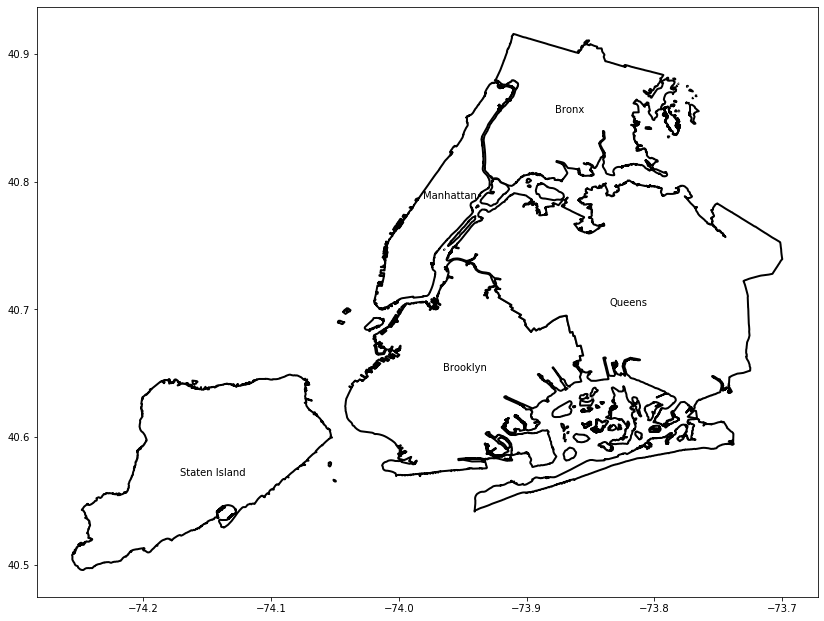

In [44]:
boro.map_gdf(show_annotations=True, fs=10)

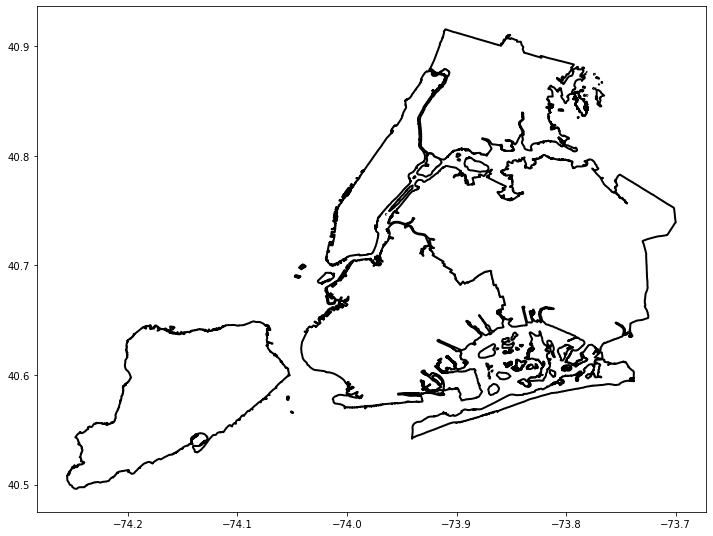

In [35]:
figsize = (12,12)
fig, ax = plt.subplots(figsize=figsize)
base = boroughs.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)

In [36]:
boroughs.head(2)

,boro_code,boro_name,shape_area,shape_leng,geometry,coords
0,2.0,Bronx,1.186612e+09,462958.188213,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...","(-73.86633177700139, 40.85607244148032)"
1,5.0,Staten Island,1.623756e+09,325960.634597,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...","(-74.14564248821605, 40.572490738411084)"


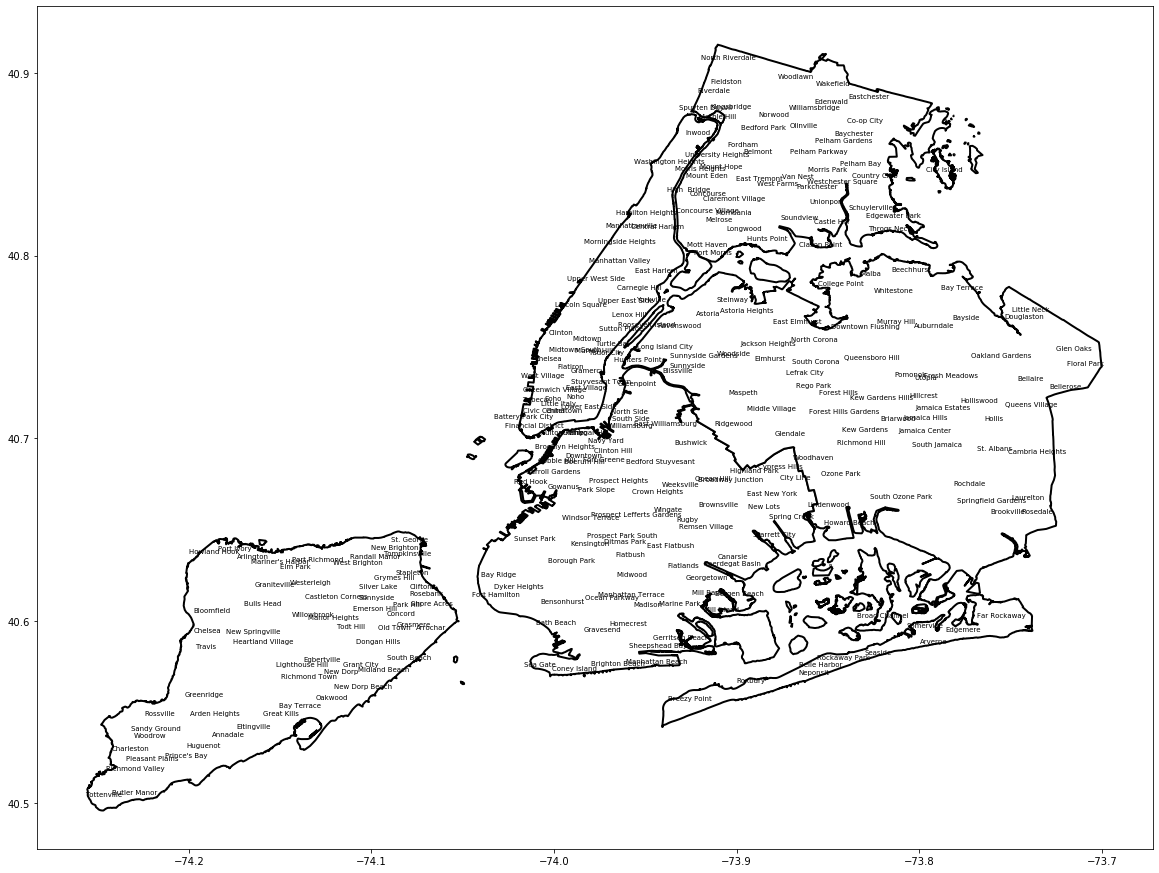

In [11]:
figsize = (20,20)
fig, ax = plt.subplots(figsize=figsize)
base = boroughs.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
for idx, row in boroughs.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=7)

In [29]:
ZIP_SHP_PATH = os.path.join('zip://', '..', 'shapefiles', 'Borough Boundaries.zip')
boroughs = gpd.read_file(ZIP_SHP_PATH)

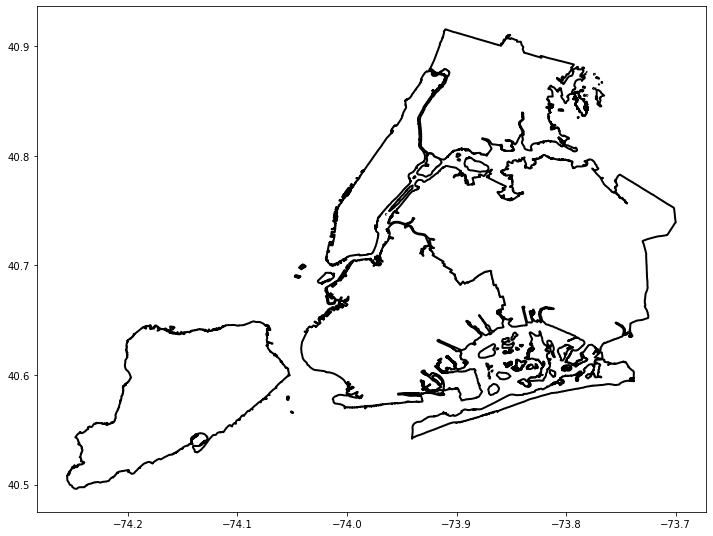

In [30]:
figsize = (12,12)
fig, ax = plt.subplots(figsize=figsize)
base = boroughs.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)

In [31]:
boroughs.head(2)

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.186612e+09,462958.188213,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,5.0,Staten Island,1.623756e+09,325960.634597,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."


In [7]:
ZIP_SHP_PATH = os.path.join('zip://', '..', 'shapefiles', 'Neighborhood Names GIS.zip')
nyc_neighborhoods = gpd.read_file(ZIP_SHP_PATH)

In [8]:
nyc_neighborhoods['coords'] = nyc_neighborhoods['geometry'].apply(lambda x: x.representative_point().coords[:])
nyc_neighborhoods['coords'] = [coords[0] for coords in nyc_neighborhoods['coords']]

In [9]:
nyc_neighborhoods.head(2)

,annoangle,annoline1,annoline2,annoline3,borough,name,objectid,stacked,geometry,coords
0,0.0,Wakefield,None,None,Bronx,Wakefield,1.0,1.0,POINT (-73.84720 40.89471),"(-73.8472005205491, 40.89470517661004)"
1,0.0,Co-op,City,None,Bronx,Co-op City,2.0,2.0,POINT (-73.82994 40.87429),"(-73.82993910812405, 40.87429419303015)"


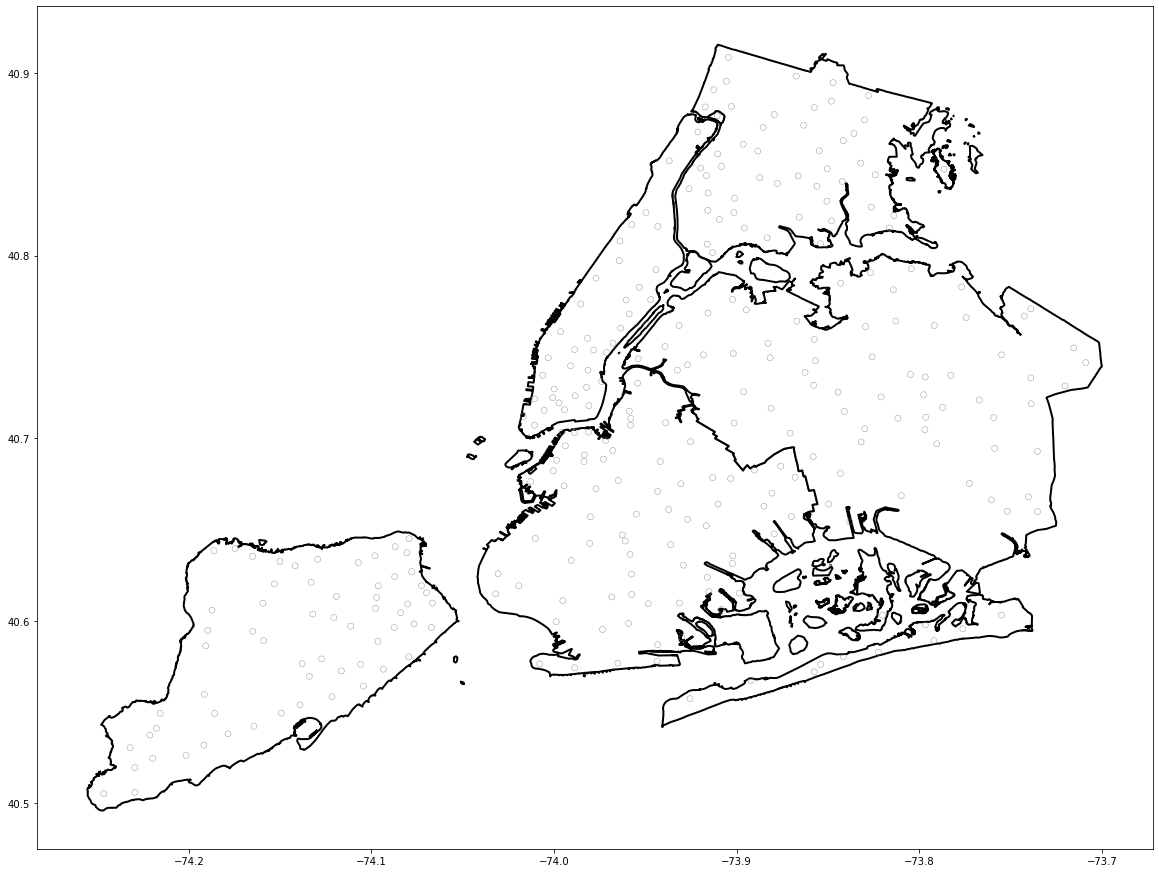

In [10]:
figsize = (20,20)
fig, ax = plt.subplots(figsize=figsize)
base = boroughs.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
ax = nyc_neighborhoods.plot(ax=base, facecolor='none', edgecolor='grey', linewidth=0.4)

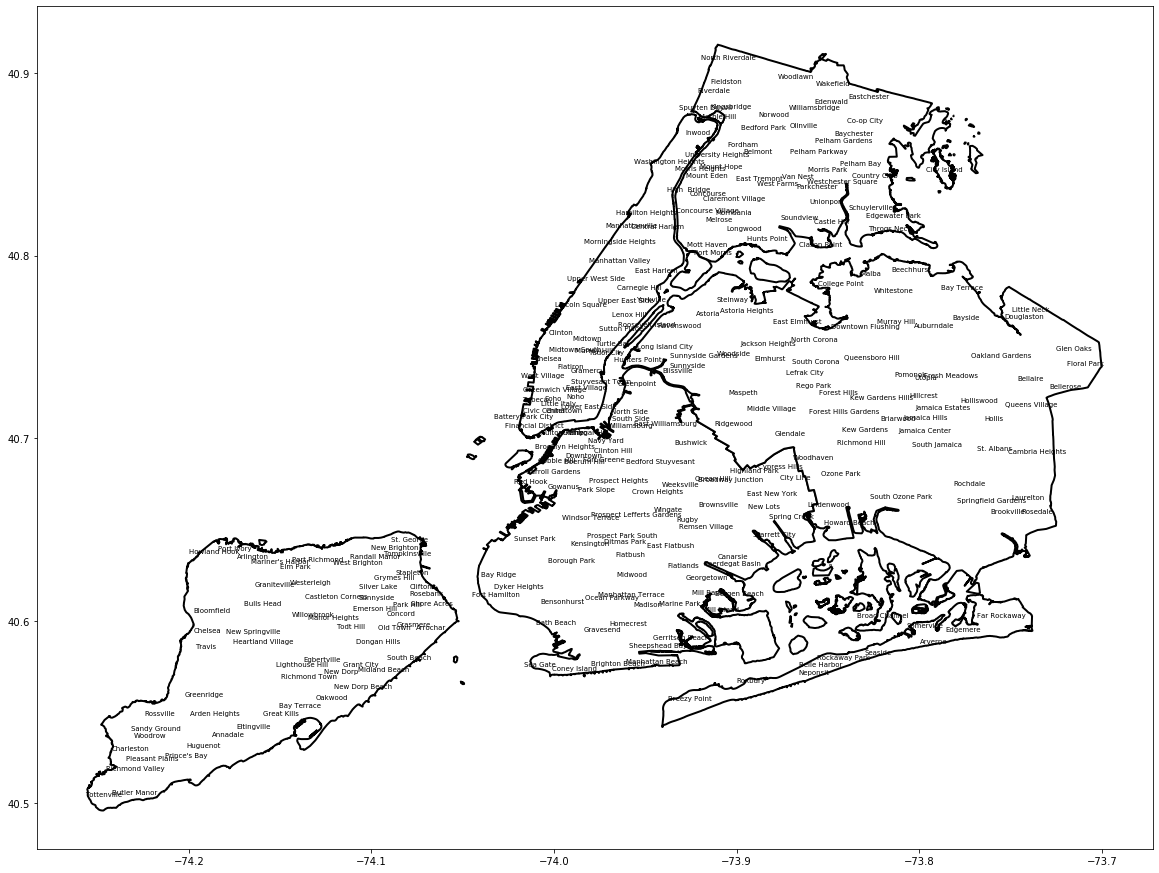

In [11]:
figsize = (20,20)
fig, ax = plt.subplots(figsize=figsize)
base = boroughs.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
ax = nyc_neighborhoods.plot(ax=base, facecolor='none', edgecolor='none', linewidth=0.4)
for idx, row in nyc_neighborhoods.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=7)

In [12]:
nyc_neighborhoods['borough'].value_counts()

Queens           78
Brooklyn         71
Staten Island    62
Bronx            49
Manhattan        39
Name: borough, dtype: int64

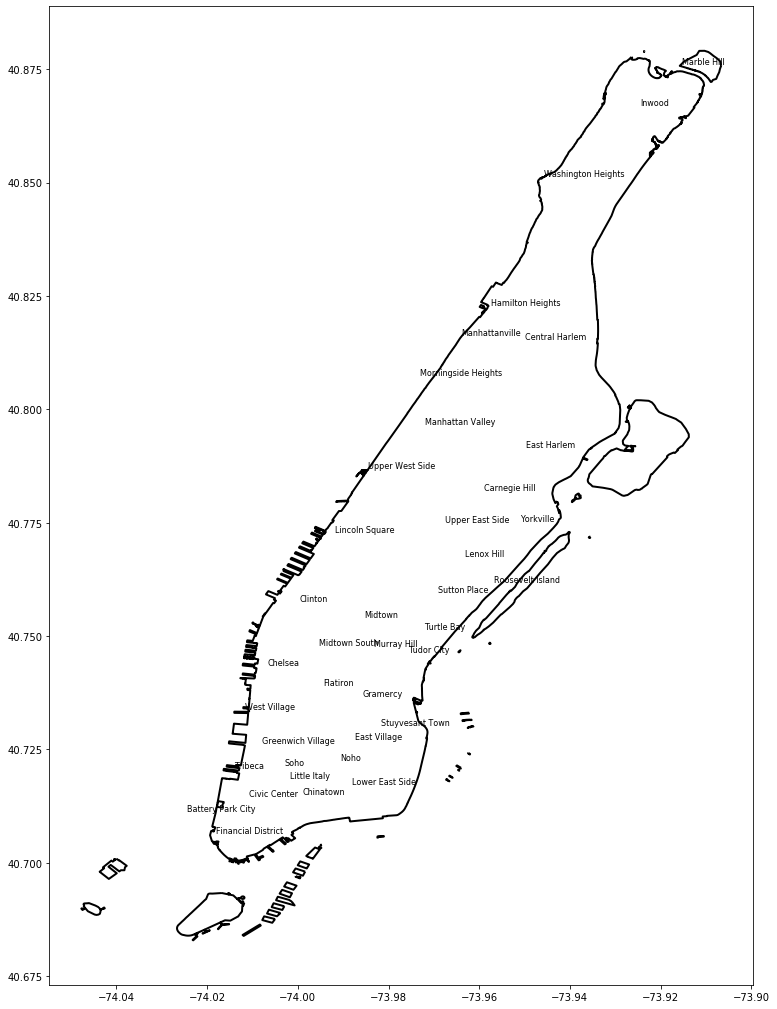

In [13]:
borough = 'Manhattan'

figsize = (18,18)
fig, ax = plt.subplots(figsize=figsize)
base = boroughs.loc[boroughs['boro_name'] == borough].plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
ax = nyc_neighborhoods.loc[nyc_neighborhoods['borough'] == borough].plot(ax=base, facecolor='none', edgecolor='none', linewidth=0.4)
for idx, row in nyc_neighborhoods.loc[nyc_neighborhoods['borough'] == borough].iterrows():
    plt.annotate(s=row['name'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=8)

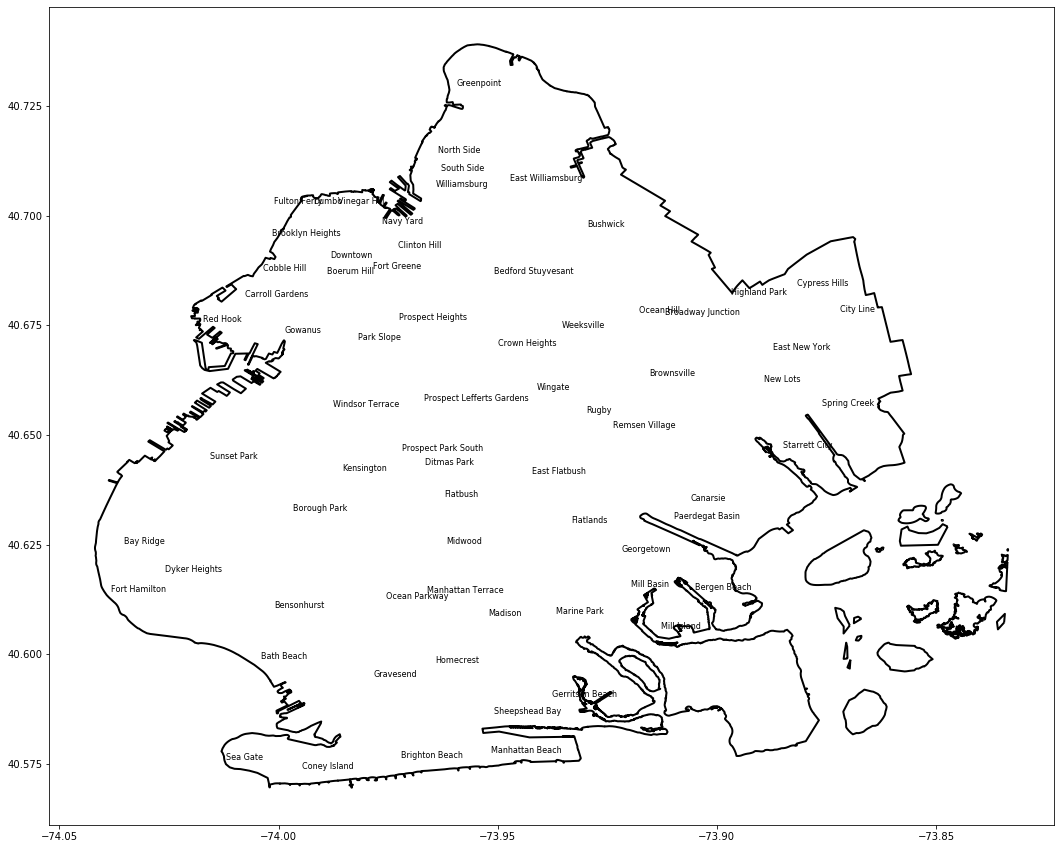

In [14]:
borough = 'Brooklyn'

figsize = (18,18)
fig, ax = plt.subplots(figsize=figsize)
base = boroughs.loc[boroughs['boro_name'] == borough].plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
ax = nyc_neighborhoods.loc[nyc_neighborhoods['borough'] == borough].plot(ax=base, facecolor='none', edgecolor='none', linewidth=0.4)
for idx, row in nyc_neighborhoods.loc[nyc_neighborhoods['borough'] == borough].iterrows():
    plt.annotate(s=row['name'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=8)

In [ ]:
class Precinct:
    

In [15]:
ZIP_SHP_PATH = os.path.join('zip://', '..', 'shapefiles', 'Police Precincts.zip')
precincts = gpd.read_file(ZIP_SHP_PATH)

In [16]:
precincts['coords'] = precincts['geometry'].apply(lambda x: x.centroid.coords)
precincts['coords'] = [coords[0] for coords in precincts['coords']]

In [17]:
precincts['precinct'] = precincts['precinct'].astype(int)

In [18]:
precincts.head(2)

,precinct,shape_area,shape_leng,geometry,coords
0,1,4.731472e+07,80797.248793,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...","(-74.012069140269, 40.70978657851407)"
1,5,1.808880e+07,18676.124259,"POLYGON ((-73.98864 40.72293, -73.98869 40.722...","(-73.99714595345321, 40.71641498826496)"


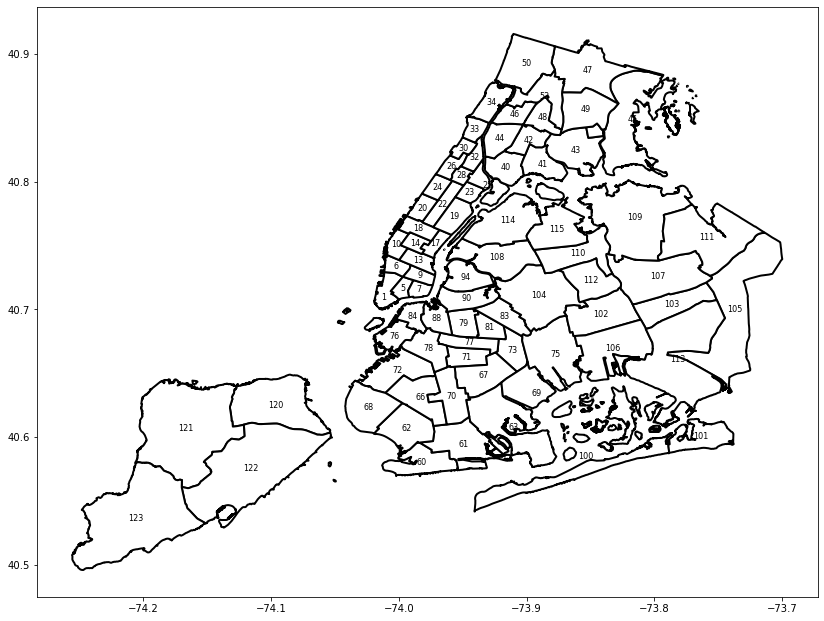

In [19]:
figsize = (14,14)
fig, ax = plt.subplots(figsize=figsize)
base = precincts.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
for idx, row in precincts.iterrows():
    plt.annotate(s=row['precinct'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=8)

## Shooting Data

From https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8

In [20]:
class ShootingHist:
    SHOOTING_HIST_PATH = os.path.join('..', 'data_raw', 'shooting', 'NYPD_Shooting_Incident_Data__Historic_.csv')
    
    def __init__(self, filepath=SHOOTING_HIST_PATH):
        self.data = pd.read_csv(filepath)
        self.preprocess_data()
        
    def preprocess_data(self):
        self.data['geometry'] = self.data.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
        self.data['JURISDICTION_CODE'] = self.data['JURISDICTION_CODE'].fillna(0).astype(int).astype(str)
        self.data['OCCUR_TIME'] = self.data.apply(
            lambda x: '0' + x['OCCUR_TIME'] if len(x['OCCUR_TIME']) == 7 else x['OCCUR_TIME'], axis=1)
        self.data['OCCUR_DATETIME'] = self.data['OCCUR_DATE'] + ' ' + self.data['OCCUR_TIME']
        self.data['OCCUR_DATETIME'] = pd.to_datetime(self.data['OCCUR_DATETIME'], 
                                                     format='%m/%d/%Y %H:%M:%S', errors='coerce')
        self.data = gpd.GeoDataFrame(self.data)
        
    def get_data(self):
        return self.data

In [21]:
shooting_hist_df = ShootingHist().get_data()

In [23]:
shooting_hist_df.head(2)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,geometry,OCCUR_DATETIME
0,169180023,09/09/2017,03:57:00,STATEN ISLAND,120,0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK,959975,171772,40.638126,-74.087467,POINT (-74.08747 40.63813),2017-09-09 03:57:00
1,169180027,09/09/2017,22:15:00,BRONX,50,0,NaN,False,NaN,NaN,NaN,25-44,M,BLACK HISPANIC,1011288,255912,40.869061,-73.902242,POINT (-73.90224 40.86906),2017-09-09 22:15:00


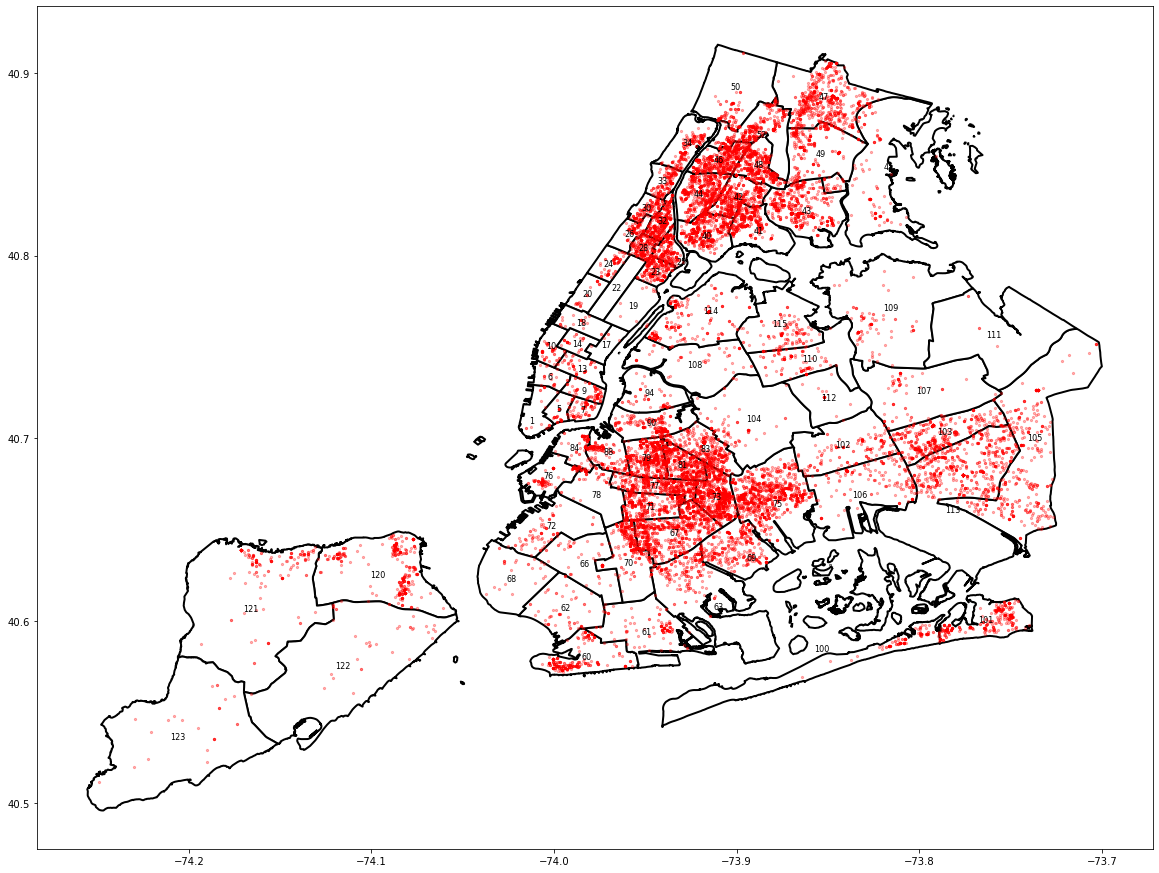

In [24]:
figsize = (20,20)
fig, ax = plt.subplots(figsize=figsize)
base = precincts.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
ax = shooting_hist_df.plot(marker='o', color='red', markersize=5, alpha=0.3, ax=ax)

for idx, row in precincts.iterrows():
    plt.annotate(s=row['precinct'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=8)

# ax.grid(None)

In [27]:
boroughs.head(1)

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.186612e+09,462958.188213,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


KeyError: 'coords'

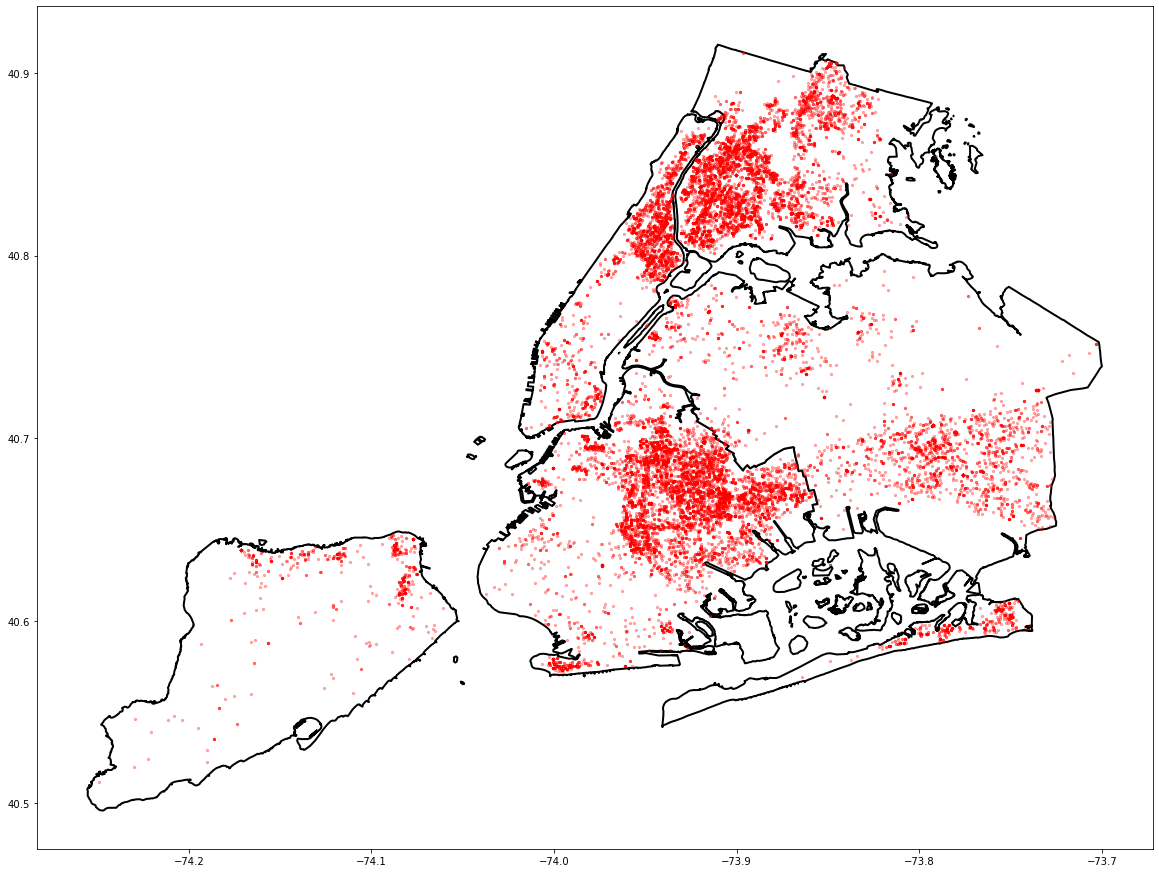

In [28]:
figsize = (20,20)
fig, ax = plt.subplots(figsize=figsize)
base = boroughs.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
ax = shooting_hist_df.plot(marker='o', color='red', markersize=5, alpha=0.3, ax=ax)

for idx, row in boroughs.iterrows():
    plt.annotate(s=row['boro_name'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=8)

# ax.grid(None)

In [20]:
# ZIP_SHP_PATH = os.path.join('zip://', '..', 'shapefiles', 'NYPD_Complaint_Data_Historic_geodata.zip')
# nyc_crimes_gdf = gpd.read_file(ZIP_SHP_PATH)

In [21]:
nyc_crimes_gdf.head(2)

,CMPLNT_NUM,ADDR_PCT_C,geometry
0,876525802,73.0,POINT (-73.91260 40.66941)
1,402693528,28.0,POINT (-73.94551 40.80198)


# Complaint Data (Historical)

https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

In [185]:
class ComplaintHist:
    COMPLAINT_HIST_PATH = os.path.join('..', 'data_raw', 'complaint', 'NYPD_Complaint_Data_Historic.csv')
    
    def __init__(self, filepath=COMPLAINT_HIST_PATH):
        self.data = pd.read_csv(filepath)
        self.preprocess_data()
        
    def preprocess_data(self):
        self.data.drop(['X_COORD_CD', 'Y_COORD_CD', 'Lat_Lon'], axis=1, inplace=True)
        self.data['JURISDICTION_CODE'] = self.data['JURISDICTION_CODE'].fillna(-99).astype(int).astype(str)
        self.data['ADDR_PCT_CD'] = self.data['ADDR_PCT_CD'].fillna(-99).astype(int).astype(str)
        self.data['PD_CD'] = self.data['PD_CD'].fillna(-99).astype(int).astype(str)
        self.data.dropna(subset=['Latitude', 'Longitude'], how='all', axis=0, inplace=True)
        self.data.dropna(subset=['CMPLNT_FR_DT', 'CMPLNT_TO_DT'], how='all', axis=0, inplace=True)
        self.data.dropna(subset=['CMPLNT_FR_TM', 'CMPLNT_TO_TM'], how='all', axis=0, inplace=True)
        self.data.loc[(self.data['CMPLNT_FR_TM'].isnull()), 'CMPLNT_FR_TM'] = self.data.loc[(self.data['CMPLNT_FR_TM'].isnull()), 'CMPLNT_TO_TM'] 
        self.data.loc[(self.data['CMPLNT_FR_DT'].isnull()), 'CMPLNT_FR_DT'] = self.data.loc[(self.data['CMPLNT_FR_DT'].isnull()), 'CMPLNT_TO_DT']
        self.data['CMPLNT_DATETIME'] = self.data['CMPLNT_FR_DT'] + ' ' + self.data['CMPLNT_FR_TM']
        self.data['CMPLNT_DATETIME'] = pd.to_datetime(self.data['CMPLNT_DATETIME'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
        self.data['RPT_DT'] = pd.to_datetime(self.data['RPT_DT'], format='%m/%d/%Y', errors='coerce')
        self.data.reset_index(drop=True, inplace=True)
        
        
    def get_complaint_type(self, offenses):
        if type(offenses) is list:
            complaint_data = self.data.loc[(self.data['OFNS_DESC'].isin(offenses))].copy()
        else:
            complaint_data = self.data.loc[(self.data['OFNS_DESC'] == offenses)].copy()
        complaint_data['geometry'] = complaint_data.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
        return gpd.GeoDataFrame(complaint_data)
        
    def get_data(self):
        return self.data

In [181]:
nyc_crimes = ComplaintHist()

C:\Users\matt\Anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3242: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [182]:
nyc_crimes_df = nyc_crimes.get_data()

In [183]:
nyc_crimes_df.head(2)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,CMPLNT_DATETIME
0,876525802,04/10/2008,19:10:00,NaN,NaN,73,2008-04-10,341,PETIT LARCENY,321,"LARCENY,PETIT FROM AUTO",COMPLETED,MISDEMEANOR,BROOKLYN,NaN,STREET,N.Y. POLICE DEPT,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.669414,-73.912603,PATROL BORO BKLYN NORTH,NaN,18-24,BLACK,M,2008-04-10 19:10:00
1,402693528,06/03/2007,15:23:00,NaN,NaN,28,2007-06-03,236,DANGEROUS WEAPONS,782,"WEAPONS, POSSESSION, ETC",COMPLETED,MISDEMEANOR,MANHATTAN,NaN,STREET,N.Y. POLICE DEPT,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.801978,-73.945511,PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E,2007-06-03 15:23:00


In [180]:
query = nyc_crimes_df['OFNS_DESC'].value_counts()
query[(query > 2000) & (query < 100000)]

INTOXICATED & IMPAIRED DRIVING     89635
VEHICLE AND TRAFFIC LAWS           78720
CRIMINAL TRESPASS                  76953
SEX CRIMES                         75337
THEFT-FRAUD                        70127
FORGERY                            65793
FRAUDS                             40802
POSSESSION OF STOLEN PROPERTY      34738
OFFENSES INVOLVING FRAUD           21189
UNAUTHORIZED USE OF A VEHICLE      18924
RAPE                               18473
ARSON                              16127
OFFENSES AGAINST THE PERSON        16033
OTHER OFFENSES RELATED TO THEF     14329
ADMINISTRATIVE CODE                14268
OTHER STATE LAWS (NON PENAL LA      6342
NYS LAWS-UNCLASSIFIED FELONY        5767
MURDER & NON-NEGL. MANSLAUGHTER     5496
THEFT OF SERVICES                   3988
BURGLAR'S TOOLS                     3310
FRAUDULENT ACCOSTING                3240
KIDNAPPING & RELATED OFFENSES       2679
GAMBLING                            2668
Name: OFNS_DESC, dtype: int64

In [186]:
nyc_murder_df = nyc_crimes.get_complaint_type(offenses=['MURDER & NON-NEGL. MANSLAUGHTER'])

In [187]:
nyc_murder_df.head(2)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,CMPLNT_DATETIME,geometry
18,205240410,04/06/2007,21:30:00,NaN,NaN,-99,2007-04-06,101,MURDER & NON-NEGL. MANSLAUGHTER,-99,NaN,COMPLETED,FELONY,NaN,OUTSIDE,NaN,N.Y. POLICE DEPT,-99,NaN,NaN,NaN,25-44,WHITE,F,NaN,NaN,NaN,NaN,NaN,UNKNOWN,WHITE,F,2007-04-06 21:30:00,POINT (nan nan)
60,443360316,04/12/2007,14:57:00,NaN,NaN,-99,2007-04-12,101,MURDER & NON-NEGL. MANSLAUGHTER,-99,NaN,COMPLETED,FELONY,NaN,INSIDE,NaN,N.Y. POLICE DEPT,-99,NaN,NaN,NaN,25-44,BLACK,M,NaN,40.832774,-73.894096,NaN,NaN,45-64,WHITE,F,2007-04-12 14:57:00,POINT (-73.894 40.833)


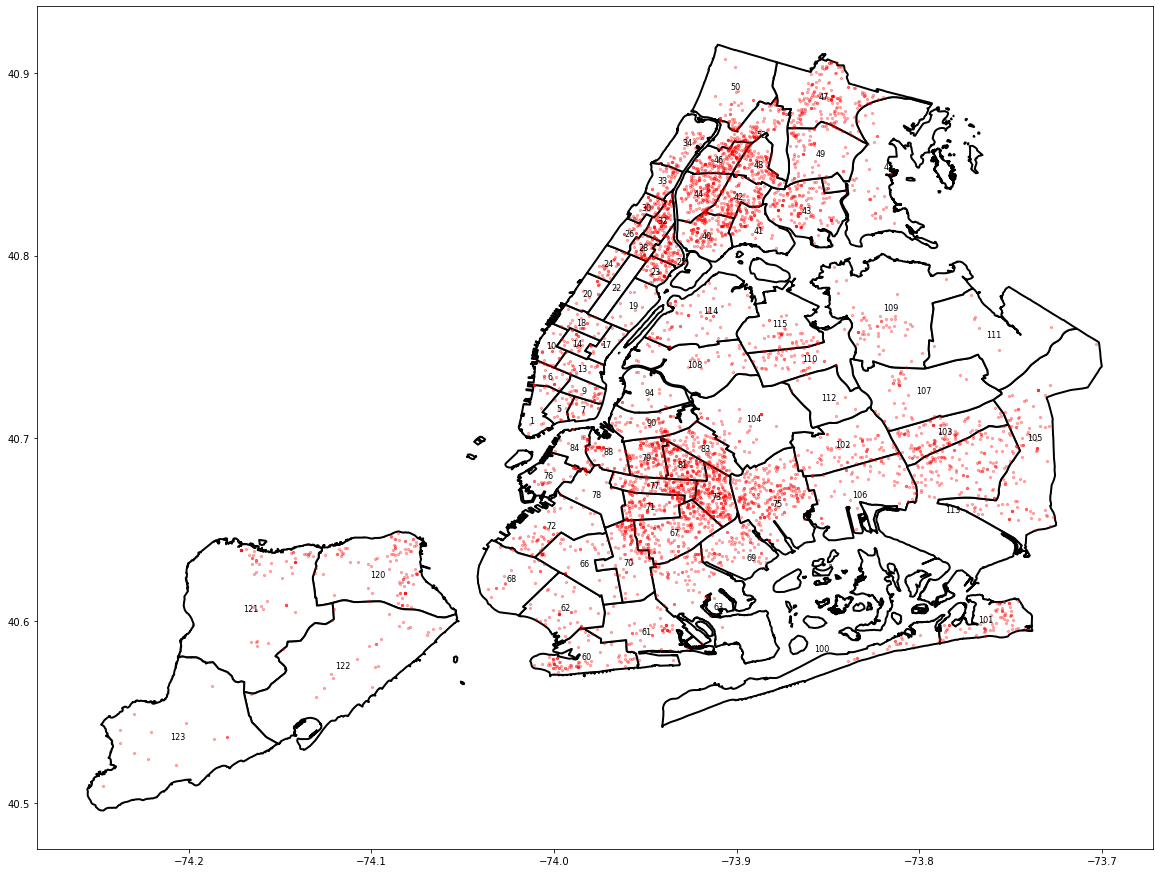

In [196]:
figsize = (20,20)
fig, ax = plt.subplots(figsize=figsize)
base = precincts.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
ax = nyc_murder_df.plot(marker='o', color='red', markersize=5, alpha=0.3, ax=ax)

for idx, row in precincts.iterrows():
    plt.annotate(s=row['precinct'], xy=row['coords'], horizontalalignment='center', verticalalignment='center', fontsize=8)

# ax.grid(None)

## Offense Code Description

In [130]:
FEATHER_PATH = os.path.join('..', 'data_raw', 'offense_codes.feather')

if not os.path.isfile(FEATHER_PATH):
    
    offense_codes = nyc_crimes[['OFNS_DESC', 'KY_CD', 'PD_DESC', 'PD_CD', 'CMPLNT_NUM']]\
                        .groupby(['OFNS_DESC', 'PD_DESC', 'PD_CD', 'KY_CD']).count().reset_index()
    offense_codes = offense_codes[['KY_CD', 'PD_CD', 'PD_DESC', 'OFNS_DESC']].copy()
    offense_codes = offense_codes.sort_values(['KY_CD', 'PD_DESC'])
    offense_codes = offense_codes.reset_index(drop=True)
    offense_codes.to_feather(FEATHER_PATH)
else:
    offense_codes = pd.read_feather(FEATHER_PATH)

In [163]:
offense_codes.head()

,KY_CD,PD_CD,PD_DESC,OFNS_DESC
0,102,122,"HOMICIDE, NEGLIGENT, VEHICLE,",HOMICIDE-NEGLIGENT-VEHICLE
1,102,121,"HOMICIDE,NEGLIGENT,VEHICLE",HOMICIDE-NEGLIGENT-VEHICLE
2,103,125,"HOMICIDE,NEGLIGENT,UNCLASSIFIE","HOMICIDE-NEGLIGENT,UNCLASSIFIE"
3,104,157,RAPE 1,RAPE
4,104,159,"RAPE 1,ATTEMPT",RAPE


In [164]:
offense_codes['KY_CD'].nunique()

73

In [165]:
offense_codes['OFNS_DESC'].nunique()

69

In [166]:
ofns_ky_df = offense_codes.drop_duplicates(subset=['KY_CD', 'OFNS_DESC'])
ofns_ky_df = ofns_ky_df[['KY_CD', 'OFNS_DESC', 'PD_DESC']].reset_index(drop=True)

In [169]:
ofns_ky_df = ofns_ky_df.sort_values('KY_CD')

In [170]:
ofns_ky_df.iloc[0:59]

,KY_CD,OFNS_DESC,PD_DESC
0,102,HOMICIDE-NEGLIGENT-VEHICLE,"HOMICIDE, NEGLIGENT, VEHICLE,"
1,103,"HOMICIDE-NEGLIGENT,UNCLASSIFIE","HOMICIDE,NEGLIGENT,UNCLASSIFIE"
2,104,RAPE,RAPE 1
3,105,ROBBERY,"ROBBERY, CHAIN STORE"
4,106,FELONY ASSAULT,"ASSAULT 2,1,UNCLASSIFIED"
5,107,BURGLARY,"BURGLARY,COMMERCIAL,DAY"
6,109,GRAND LARCENY,GRAND LARCENY-CHECK FROM MAILB
7,110,GRAND LARCENY OF MOTOR VEHICLE,"LARCENY, GRAND OF AUTO - ATTEM"
8,111,POSSESSION OF STOLEN PROPERTY,"STOLEN PROPERTY 2,1,POSSESSION"
9,112,THEFT-FRAUD,COMPUTER TAMPER/TRESSPASS


## Handling Missing OFNS_DESC values

In [147]:
nyc_crimes.loc[nyc_crimes['OFNS_DESC'].isnull(), 'PD_CD'].isnull().sum()

0

In [159]:
nyc_crimes.loc[nyc_crimes['PD_DESC'].isnull(), 'OFNS_DESC'].value_counts()

MURDER & NON-NEGL. MANSLAUGHTER    5496
Name: OFNS_DESC, dtype: int64

In [152]:
ofns_ky_df.head()

,KY_CD,OFNS_DESC,PD_DESC
21,123,ABORTION,ABORTION 1
66,365,ADMINISTRATIVE CODE,"ADM.CODE,UNCLASSIFIED MISDEMEA"
75,675,ADMINISTRATIVE CODE,"ADM.CODE,UNCLASSIFIED VIOLATIO"
80,685,ADMINISTRATIVE CODES,"NOISE,UNECESSARY"
63,364,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ABANDON ANIMAL


In [154]:
ofns_ky_df.loc[ofns_ky_df['OFNS_DESC'].str.contains('MURDER')]

,KY_CD,OFNS_DESC,PD_DESC


In [171]:
nyc_crimes.loc[nyc_crimes['OFNS_DESC'].str.contains('MURDER')]

ValueError: cannot index with vector containing NA / NaN values

In [155]:
ofns_ky_df.loc[ofns_ky_df['OFNS_DESC'].str.contains('HOMICIDE')]

,KY_CD,OFNS_DESC,PD_DESC
1,103,"HOMICIDE-NEGLIGENT,UNCLASSIFIE","HOMICIDE,NEGLIGENT,UNCLASSIFIE"
0,102,HOMICIDE-NEGLIGENT-VEHICLE,"HOMICIDE, NEGLIGENT, VEHICLE,"


In [156]:
ofns_ky_df.loc[ofns_ky_df['PD_DESC'].str.contains('HOMICIDE')]

,KY_CD,OFNS_DESC,PD_DESC
1,103,"HOMICIDE-NEGLIGENT,UNCLASSIFIE","HOMICIDE,NEGLIGENT,UNCLASSIFIE"
0,102,HOMICIDE-NEGLIGENT-VEHICLE,"HOMICIDE, NEGLIGENT, VEHICLE,"


In [107]:
# point_maker = lambda x: Point(x['Longitude'], x['Latitude'])
# nyc_crimes['geometry'] = nyc_crimes.apply(point_maker, axis=1)

In [108]:
nyc_crimes.loc[nyc_crimes['ADDR_PCT_CD'].isnull()]

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,incident_start,incident_end,geometry
18,205240410,04/06/2007,21:30:00,NaN,NaN,NaN,2007-04-06,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,OUTSIDE,NaN,N.Y. POLICE DEPT,NaN,NaN,NaN,None,NaN,NaN,25-44,WHITE,F,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,WHITE,F,2007-04-06 21:30:00,NaT,POINT (nan nan)
60,443360316,04/12/2007,14:57:00,NaN,NaN,NaN,2007-04-12,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,INSIDE,NaN,N.Y. POLICE DEPT,NaN,NaN,NaN,None,1013557.0,242694.0,25-44,BLACK,M,NaN,40.832774,-73.894096,"(40.832773975, -73.894096197)",NaN,NaN,45-64,WHITE,F,2007-04-12 14:57:00,NaT,POINT (-73.894096197 40.832773975)
90,342597863,01/28/2007,03:50:00,NaN,NaN,NaN,2007-01-28,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,INSIDE,NaN,N.Y. POLICE DEPT,NaN,NaN,NaN,None,1008627.0,241071.0,25-44,BLACK,M,NaN,40.828334,-73.911917,"(40.82833429, -73.911917378)",NaN,NaN,45-64,BLACK,M,2007-01-28 03:50:00,NaT,POINT (-73.911917378 40.82833429)
94,457665109,06/13/2008,16:00:00,NaN,NaN,NaN,2008-06-13,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,INSIDE,NaN,N.Y. TRANSIT POLICE,NaN,NaN,NaN,None,NaN,NaN,<18,BLACK HISPANIC,M,NaN,NaN,NaN,NaN,NaN,NaN,<18,WHITE HISPANIC,M,2008-06-13 16:00:00,NaT,POINT (nan nan)
125,492473011,05/27/2007,00:20:00,NaN,NaN,NaN,2007-05-27,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,OUTSIDE,NaN,N.Y. HOUSING POLICE,NaN,NaN,NaN,None,NaN,NaN,<18,BLACK,M,NaN,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,2007-05-27 00:20:00,NaT,POINT (nan nan)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351883,932141534,01/12/2013,09:30:00,NaN,NaN,NaN,2013-01-12,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,INSIDE,NaN,N.Y. POLICE DEPT,NaN,NaN,SHEEPSHEAD BAY,None,1001352.0,156950.0,45-64,BLACK,M,NaN,40.597459,-73.938419,"(40.59745944, -73.938418599)",NaN,NaN,45-64,BLACK,F,2013-01-12 09:30:00,NaT,POINT (-73.938418599 40.59745944)
6389342,566173338,08/21/2012,23:30:00,NaN,NaN,NaN,2012-08-21,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,OUTSIDE,NaN,N.Y. POLICE DEPT,NaN,NaN,NaN,None,1014746.0,255254.0,25-44,BLACK HISPANIC,M,NaN,40.867243,-73.889742,"(40.867243413, -73.889742444)",NaN,NaN,25-44,BLACK,M,2012-08-21 23:30:00,NaT,POINT (-73.88974244399999 40.867243413)
6410035,554566693,08/26/2012,18:28:00,NaN,NaN,NaN,2012-08-26,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,OUTSIDE,NaN,N.Y. POLICE DEPT,NaN,NaN,NaN,None,991313.0,151648.0,45-64,WHITE,M,NaN,40.582920,-73.974574,"(40.582920192, -73.974573718)",NaN,NaN,45-64,WHITE,M,2012-08-26 18:28:00,NaT,POINT (-73.974573718 40.582920192)
6449854,353090926,10/29/2012,03:40:00,NaN,NaN,NaN,2012-10-29,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,COMPLETED,FELONY,NaN,OUTSIDE,NaN,N.Y. POLICE DEPT,NaN,NaN,NaN,None,985771.0,156637.0,18-24,WHITE HISPANIC,M,NaN,40.596617,-73.994525,"(40.596616686, -73.994524518)",NaN,NaN,25-44,WHITE HISPANIC,M,2012-10-29 03:40:00,NaT,POINT (-73.99452451800001 40.596616686)


In [109]:
nyc_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500870 entries, 0 to 6500869
Data columns (total 38 columns):
CMPLNT_NUM           int64
CMPLNT_FR_DT         object
CMPLNT_FR_TM         object
CMPLNT_TO_DT         object
CMPLNT_TO_TM         object
ADDR_PCT_CD          float64
RPT_DT               datetime64[ns]
KY_CD                int64
OFNS_DESC            object
PD_CD                float64
PD_DESC              object
CRM_ATPT_CPTD_CD     object
LAW_CAT_CD           object
BORO_NM              object
LOC_OF_OCCUR_DESC    object
PREM_TYP_DESC        object
JURIS_DESC           object
JURISDICTION_CODE    float64
PARKS_NM             object
HADEVELOPT           object
HOUSING_PSA          object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP       object
SUSP_RACE            object
SUSP_SEX             object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon              object
PATROL_BORO          object
STATI

In [93]:
FEATHER_OUT_PATH = os.path.join('..', 'data_raw', 'NYPD_Complaint_Data_Historic_preprocessed.feather')
nyc_crimes.to_feather(FEATHER_OUT_PATH) 

In [110]:
nyc_crimes.head(2)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,incident_start,incident_end,geometry
0,876525802,04/10/2008,19:10:00,NaN,NaN,73.0,2008-04-10,341,PETIT LARCENY,321.0,"LARCENY,PETIT FROM AUTO",COMPLETED,MISDEMEANOR,BROOKLYN,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,None,1008495.0,183171.0,NaN,NaN,NaN,NaN,40.669414,-73.912603,"(40.669413836, -73.91260308)",PATROL BORO BKLYN NORTH,NaN,18-24,BLACK,M,2008-04-10 19:10:00,NaT,POINT (-73.91260308 40.669413836)
1,402693528,06/03/2007,15:23:00,NaN,NaN,28.0,2007-06-03,236,DANGEROUS WEAPONS,782.0,"WEAPONS, POSSESSION, ETC",COMPLETED,MISDEMEANOR,MANHATTAN,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,None,999336.0,231461.0,NaN,NaN,NaN,NaN,40.801978,-73.945511,"(40.801978284, -73.945511151)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E,2007-06-03 15:23:00,NaT,POINT (-73.94551115100001 40.801978284)


In [111]:
nyc_crime_geo = nyc_crimes[['CMPLNT_NUM', 'ADDR_PCT_CD', 'geometry']].copy()

In [114]:
nyc_crime_geo = gpd.GeoDataFrame(nyc_crime_geo)

In [115]:
nyc_crime_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6500870 entries, 0 to 6500869
Data columns (total 3 columns):
CMPLNT_NUM     int64
ADDR_PCT_CD    float64
geometry       geometry
dtypes: float64(1), geometry(1), int64(1)
memory usage: 148.8 MB


In [116]:
SHP_OUT_PATH = os.path.join('..', 'shapefiles', 'NYPD_Complaint_Data_Historic_geodata.shp')
nyc_crime_geo.to_file(SHP_OUT_PATH)

In [125]:
zipObj.close()

ValueError: Can't close the ZIP file while there is an open writing handle on it. Close the writing handle before closing the zip.

In [112]:
FEATHER_OUT_PATH = os.path.join('..', 'data_raw', 'NYPD_Complaint_Data_Historic_geodata.feather')
nyc_crime_geo.to_feather(FEATHER_OUT_PATH) 

ArrowInvalid: ('Could not convert POINT (-73.91260308 40.669413836) with type Point: did not recognize Python value type when inferring an Arrow data type', 'Conversion failed for column geometry with type object')

In [96]:
nyc_crimes['OFNS_DESC'].value_counts()

PETIT LARCENY                       1072782
HARRASSMENT 2                        806647
ASSAULT 3 & RELATED OFFENSES         677723
CRIMINAL MISCHIEF & RELATED OF       650495
GRAND LARCENY                        560269
                                     ...   
OTHER STATE LAWS (NON PENAL LAW)         10
ABORTION                                  7
UNDER THE INFLUENCE OF DRUGS              3
OFFENSES AGAINST MARRIAGE UNCL            3
KIDNAPPING AND RELATED OFFENSES           2
Name: OFNS_DESC, Length: 70, dtype: int64

# Data Sources

The Chicago crimes data set used in this notebook is publicly available on the [Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), as are the shapefiles for the current [Chicago police beats](https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74).


In [4]:
def process_chicrimes(chi_crimes):
    chi_crimes['Date'] = pd.to_datetime(chi_crimes['Date'], format='%m/%d/%Y %I:%M:%S %p')
    chi_crimes['Updated On'] = pd.to_datetime(chi_crimes['Updated On'], format='%m/%d/%Y %I:%M:%S %p')
    chi_crimes.drop(['Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
    chi_crimes['Block'] = chi_crimes['Block'].astype('category')
    chi_crimes['IUCR'] = chi_crimes['IUCR'].astype('category')
    chi_crimes['Primary Type'] = chi_crimes['Primary Type'].astype('category')
    chi_crimes['Description'] = chi_crimes['Description'].astype('category')
    chi_crimes['Location Description'] = chi_crimes['Primary Type'].astype('category')
    chi_crimes['Beat'] = chi_crimes['Beat'].astype(int)
    chi_crimes['District'] = chi_crimes['District'].astype('category')
    chi_crimes['Ward'] = chi_crimes['Ward'].astype('category')
    chi_crimes['Community Area'] = chi_crimes['Community Area'].astype('category')
    chi_crimes['FBI Code'] = chi_crimes['FBI Code'].astype('category')
    chi_crimes['Hour'] = chi_crimes['Date'].dt.hour
    chi_crimes['Week'] = chi_crimes['Date'].dt.weekofyear
    chi_crimes['Day'] = chi_crimes['Date'].dt.dayofyear
    chi_crimes['Weekday_name'] = chi_crimes['Date'].dt.day_name()
    chi_crimes['Weekday'] = chi_crimes['Date'].dt.dayofweek
    chi_crimes['Month'] = chi_crimes['Date'].dt.month
    chi_crimes['Hour'] = chi_crimes['Hour'].astype('category')
    chi_crimes['Week'] = chi_crimes['Week'].astype('category')
    chi_crimes['Day'] = chi_crimes['Day'].astype('category')
    chi_crimes['Weekday'] = chi_crimes['Weekday'].astype('category')
    chi_crimes['Month'] = chi_crimes['Month'].astype('category')
    return chi_crimes

In [5]:
CSV_PATH = os.path.join('..', 'data_raw', 'Crimes_-_2001_to_present.csv')
crime_dtypes = {'District':str,
                'Ward':str, 
                'Community Area':str}
chi_crimes = pd.read_csv(CSV_PATH, dtype=crime_dtypes, encoding='latin1') 

C:\Users\mattt\Anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
chi_crimes.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,412,004,8,45,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,2222,022,21,73,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [7]:
chi_crimes = process_chicrimes(chi_crimes)

In [8]:
def freq_selector(freq):
    freq = freq.lower()
    if freq == 'month':
        return 'M'
    elif freq == 'quarter':
        return 'Q'
    else:
        return 'Y'

In [9]:
def arrest_plot(crime_descr, crime_df=chi_crimes, crime_col='Description', start_date='2005-01-01', 
                end_date='today', frequency='Year', arrest=True, figsize=(14,6), more_label='', plot_Laquan=False):
    lable_descr = crime_descr.title()
    
    if isinstance(crime_descr, list):
        df = crime_df.loc[(chi_crimes[crime_col].isin(crime_descr)) & (chi_crimes['Date'] >= start_date) & 
                          (chi_crimes['Date'] <= end_date)]
    else:
        df = crime_df.loc[(chi_crimes[crime_col] == crime_descr) & (chi_crimes['Date'] >= start_date) & 
                          (chi_crimes['Date'] <= end_date)]
    
    fig, ax = plt.subplots(sharex=True, figsize=figsize)
    count_df = df.groupby([pd.Grouper(key='Date', freq=freq_selector(frequency))]).count()['Case Number']
    count_df.plot(ax=ax, kind='line', legend=None, label=f"{lable_descr} Cases", color='#0570b0')
    arr_count_df = df.loc[df['Arrest'] == True].groupby([pd.Grouper(key='Date', freq=freq_selector(frequency))]).count()['Case Number']
    arr_count_df.plot(ax=ax, kind='line', legend=None, label=f"{lable_descr} Cases w/ Arrest", color='#41ae76')
    
    ax.set_ylabel(f"{lable_descr} Cases \n(per {frequency})", fontsize=18)
    ax.set_title(f"{more_label}{lable_descr} Cases per {frequency} from {start_date} to {end_date}", fontsize=18)
    ax.set_xlabel('Date', fontsize=18)
    
    ax.set_ylim([0, 1.1 * max([count_df.max(), arr_count_df.max()])])
    if plot_Laquan:
        if freq_selector(frequency) == 'Y':
            ax.axvline(x='2015-04-15', label='Laquan McDonald becomes major News', linestyle='--', color='#b30000')
#             ax.axvline(x='2015', label='Laquan McDonald Shooting', linestyle='--', color='#ef6548')
        else:
            ax.axvline(x='2014-11-01', label='Laquan McDonald Shooting', linestyle='--', color='#ef6548')
            ax.axvline(x='2015-04-15', label='Laquan McDonald becomes major News', linestyle='--', color='#b30000')
    ax.legend()    

In [10]:
ZIP_SHP_PATH = os.path.join('zip://', '..', 'data_raw', 'Boundaries - Police Beats (current).zip')
beats = gpd.read_file(ZIP_SHP_PATH)
beats['beat_num'] = beats['beat_num'].astype('int64')

In [11]:
def map_counts(crime_descr, crime_col='Primary Type', df_=chi_crimes, start_date='2001-01-01', more_label='',
               end_date='2019-01-03', gdf=beats, figsize=(10,10), my_cmap='YlGn', scale=0.6, tight=True, title_fs=None):
    df = df_[(df_['Date'] >= start_date) & (df_['Date'] <= end_date) & (df_[crime_col] == crime_descr.upper())]
    count_df = df.groupby(['Beat', crime_col]).count()['Case Number'].unstack(fill_value=0).stack().reset_index()
    count_df.rename({0:'Count'}, axis=1, inplace=True)
    
    map_df = pd.merge(left=gdf, right=count_df.loc[count_df[crime_col] == crime_descr.upper()], right_on='Beat', left_on='beat_num', how='left')
    map_df['Count'] = map_df['Count'].fillna(0)
    vmin = map_df['Count'].min()
    vmax = map_df['Count'].max()
    fig, ax = plt.subplots(figsize=figsize)
    base = gdf.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
    map_df.plot(column='Count', ax=base, edgecolor='grey', linewidth=0.4, cmap=my_cmap)
    _ = ax.axis('off')
    title = f"{more_label}{crime_descr} cases per police beat\nfrom {start_date} to {end_date}"
    if len(title) >= 60:
        title = f"{more_label}{crime_descr} cases\nper police beat from {start_date} to {end_date}"
        if not title_fs:
            title_fs = 22
    if not title_fs:
        title_fs = 25
    _ = ax.set_title(title, fontdict={'fontsize': title_fs, 'fontweight':'3'})
    
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    if tight:
        plt.tight_layout()

In [12]:
def plot_crime_freq_heatmap(crime_descr, crime_col='Primary Type', x_ax='Weekday', y_ax='Hour',  more_label='',
                            start_date='2001-01-01', end_date='today', df=chi_crimes, cmap='YlGn', figsize=None):
    tmp_df = chi_crimes.loc[(chi_crimes['Date'] >= start_date) & (chi_crimes['Date'] <= end_date) & (chi_crimes[crime_col] == crime_descr)]
    tmp_counts = tmp_df.groupby([tmp_df[y_ax], tmp_df[x_ax]])['ID'].count()
    tmp_counts = tmp_counts.unstack(level=1, fill_value=0)
    
    weekday_names = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    if x_ax == 'Weekday':
        tmp_counts.columns = tmp_counts.columns.rename_categories(weekday_names)
    if x_ax == 'Month':
        tmp_counts.columns = tmp_counts.columns.rename_categories(month_names)
    if y_ax == 'Weekday':
        if not figsize:
            figsize=(14,4)
        tmp_counts.index = tmp_counts.index.rename_categories(weekday_names)
        y_top = 7
        y_bot = 0
    if y_ax == 'Month':
        if not figsize:
            figsize=(14,6)
        tmp_counts.index = tmp_counts.index.rename_categories(month_names)
        y_top = 12
        y_bot = 1
    if y_ax == 'Hour':
        if not figsize:
            figsize=(14,7)
        y_top = max(list(tmp_counts.index))+1
        y_bot = min(list(tmp_counts.index))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(tmp_counts, ax=ax, annot=False, fmt='d', cmap=cmap)
    ax.tick_params(axis='y', rotation=0)
    ax.set_ylim([y_top, y_bot])
    ax.set_xlabel(x_ax, fontsize=14)
    ax.set_ylabel(y_ax, fontsize=14)
    title = f"Frequency of crime: '{more_label}{crime_descr}' by {y_ax} and {x_ax} from {start_date} to {end_date}"
    if len(title) > 70:
        title = f"Frequency of crime: '{more_label}{crime_descr}' by\n{y_ax} and {x_ax} from {start_date} to {end_date}"
    ax.set_title(title, fontsize=16)
    plt.tight_layout()

# Notebook Default Dates

In [14]:
nb_start_date='2015-01-01'
nb_end_date='2019-11-22'

In [15]:
def produce_visualizations(crime_descr, crime_col='Description', start_date=nb_start_date, end_date=nb_end_date, 
                           more_label='', qmin=0, qmax=1000000):
    if crime_col == 'Primary Type':
        print(f"Number of {crime_descr} Cases by description since 2001")
        query = chi_crimes.loc[(chi_crimes['Primary Type'] == crime_descr), 'Description'].value_counts()
        display(query[(query > qmin) & (query < qmax)])
    arrest_plot(crime_descr=crime_descr, crime_col=crime_col, frequency='year', end_date=end_date, more_label=more_label)
    arrest_plot(crime_descr=crime_descr, crime_col=crime_col, frequency='month', end_date=end_date, more_label=more_label)
    plot_crime_freq_heatmap(crime_descr=crime_descr, crime_col=crime_col, x_ax='Hour', y_ax='Weekday', 
                            start_date=start_date, end_date=end_date, more_label=more_label.upper())
    plot_crime_freq_heatmap(crime_descr=crime_descr, crime_col=crime_col, x_ax='Hour', y_ax='Month', 
                            start_date=start_date, end_date=end_date, more_label=more_label.upper())
    plot_crime_freq_heatmap(crime_descr=crime_descr, crime_col=crime_col, x_ax='Month', y_ax='Weekday', 
                            start_date=start_date, end_date=end_date, figsize=(10,5), more_label=more_label.upper())
    map_counts(crime_descr=crime_descr, crime_col=crime_col, start_date=start_date, end_date=end_date, 
               scale=0.65, more_label=more_label.upper())